Código Disponível em: https://github.com/derSchmetterling/multivariate_analysis 

# Pedro Vinícius Alves Silva - 10727865

In [2]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import seaborn as sns
from scipy.stats import t
import scipy as sc
from scipy.stats import chi2


In [3]:
import os
os.environ['R_HOME'] = '/Users/alves/anaconda3/envs/deep-networks/Lib/R'

%load_ext rpy2.ipython

C:\Users\alves\anaconda3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


# Questão 2

## a) Modelo

In [17]:
df = pd.read_csv('exp_table.csv', sep = ',')
df.columns

Index(['Experimento', 'Y1', 'Y2', 'Y3', 'X1', 'X2', 'X3'], dtype='object')

In [8]:
from sklearn import linear_model
y = df[['Y1','Y2','Y3']]
x = df[['X1','X2','X3']]
clf = linear_model.LinearRegression().fit(x,y)
clf.coef_, clf.intercept_


(array([[-1.54596082, -1.42455873, -2.23736565],
        [ 0.40455059,  0.29298999,  1.03380047],
        [ 0.91392477,  0.89947254,  1.15348549]]),
 array([ 332.11098334,  -26.03526431, -164.0789411 ]))

In [9]:
betas = np.vstack([clf.intercept_, clf.coef_.T])
z = sm.add_constant(x.to_numpy())
yi = y.to_numpy()



def regression(z,yi):
    '''
    Multiple regression
    '''
    reg = np.dot(np.linalg.inv(np.dot(z.T,z)), z.T)
    betas = np.dot(reg,yi)
    
    errors = yi - np.dot(z,betas)
    sqres = np.dot(errors.T, errors)
    ssq = np.dot(yi.T,yi)    
    
    return betas, sqres, ssq


def prediction(betas, z,yi):
    predicted = np.dot(z,betas)
    errors = yi - predicted
    
    return predicted, errors

def sigma(yi,z, betas):
    '''
    Calculates the hat(SIGMA) matrix, biased covariance matrix of the errors
    '''
    n = len(yi)
    a = yi - np.dot(z,betas)
    sigma = 1/n*np.dot(a.T,a)
    return sigma
    

In [10]:
m1 = smf.ols('Y1 ~ X1 + X2 + X3', data=df).fit()
m2 = smf.ols('Y2 ~ X1 + X2 + X3', data=df).fit()
m3 = smf.ols('Y3 ~ X1 + X2 + X3', data=df).fit()
print(f'Y1 \n{m1.params} \nY2 \n{m2.params} \nY3 \n{m3.params}')

Y1 
Intercept    332.110983
X1            -1.545961
X2            -1.424559
X3            -2.237366
dtype: float64 
Y2 
Intercept   -26.035264
X1            0.404551
X2            0.292990
X3            1.033800
dtype: float64 
Y3 
Intercept   -164.078941
X1             0.913925
X2             0.899473
X3             1.153485
dtype: float64


Assim, os modelos gerados são dados por:

$$
Y_1 = 332.110 -1.545 X_1 - 1.424X_2 - 2.237 X_3 \\
Y_2 = -26.035 + 0.404 X_1 + 0.292 X_2 + 1.033 X_3 \\
Y_3 = -164.078 + 0.913 X_1 + 0.899 X_2 + 1.153 X_3 \\
$$


em que cada coeficiente representa o impacto da mudança de uma unidade da covariável a qual ele está associado, a variável resposta.

## b) Suposições do modelo

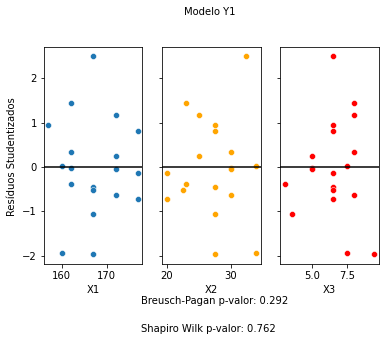

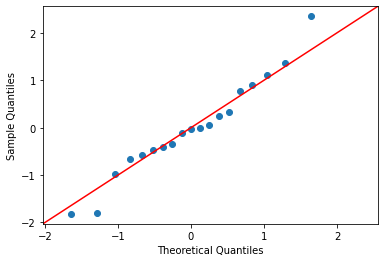

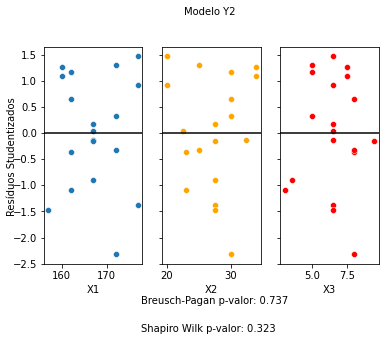

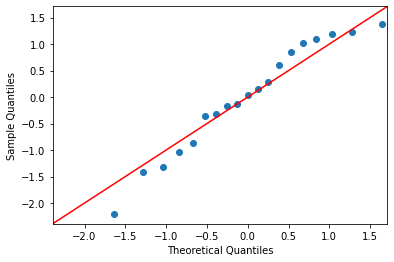

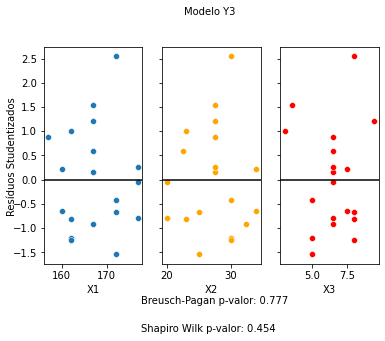

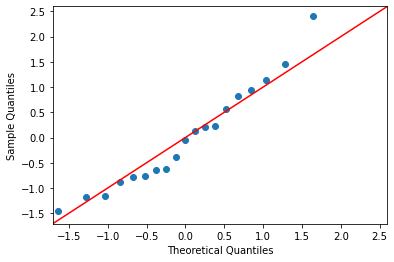

In [11]:
def student_residuals(results, df_treated, dependent):
    x = df_treated[['X1', 'X2','X3']].to_numpy()

    
    errors = df_treated[dependent].to_numpy() - results.predict()
    hat = np.dot(np.dot(x,np.linalg.inv(np.dot(x.T, x))),x.T)
    hat_diag = hat.diagonal()
    student = []
    s1 = round(sc.stats.shapiro(results.resid)[1],3)
    bp = round(sms.het_breuschpagan(results.resid, results.model.exog)[1],3)
    for i in range(0,len(hat_diag)):
        e = errors[i]/np.sqrt(errors.var(ddof = 1)*(1-hat_diag[i]))
        student.append(e)
    
    fig, axs = plt.subplots(ncols=3, sharey = True)
    fig.text(0.45, 1, f'Modelo {dependent}', va='center', rotation='horizontal')
    fig.text(0.04, 0.5, 'Resíduos Studentizados', va='center', rotation='vertical')
    a = sns.scatterplot(x = df_treated['X1'], y = student, ax = axs[0])
    b = sns.scatterplot(x = df_treated['X2'], y = student, ax = axs[1], color = 'orange')
    c = sns.scatterplot(x = df_treated['X3'], y = student, ax = axs[2], color = 'red')
    fig.text(0.35, -0.003, f'Breusch-Pagan p-valor: {bp}', va='center', rotation='horizontal')
    fig.text(0.35, -0.1, f'Shapiro Wilk p-valor: {s1}', va='center', rotation='horizontal')


    a.axhline(0, color = 'black')
    b.axhline(0, color = 'black')
    c.axhline(0, color = 'black')
    qqplot = sm.qqplot(np.array(student), fit=True, line="45")

    
    
    
dep = {'Y1': m1, 'Y2': m2, 'Y3': m3}
for i in dep.keys():
    student_residuals(dep[i], df, i)

Analisando os gráficos de resíduos, não notamos grandes tendência em sua distribuição e nem desvios graves no gráfico de QQPlot em relação a reta afim. Pelo teste de Shapiro Wilk, concluimos que a distribuição desses resíduos pode ser considerada normal e, pelo teste de Breusch-Pagan, que sua variância é constante.

## c) Significância da regressão

In [ ]:
Em seguida, testamos a significância dos coeficientes de regressão

In [38]:
%%R

df = read.csv('exp_table.csv', sep = ',', header = TRUE)
y = as.matrix(df[,c("Y1","Y2","Y3")])
model = lm(y ~ X1 + X2 + X3, data = df)
null = lm(y ~ 1, data = df)
anova(model, null, test = 'Wilks')

Analysis of Variance Table

Model 1: y ~ X1 + X2 + X3
Model 2: y ~ 1
  Res.Df Df Gen.var.    Wilks approx F num Df den Df    Pr(>F)    
1     15      4.6266                                              
2     18  3  12.0012 0.033158   10.787      9 31.789 1.884e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [40]:
%%R
anova(model, null, test = 'Pillai')

Analysis of Variance Table

Model 1: y ~ X1 + X2 + X3
Model 2: y ~ 1
  Res.Df Df Gen.var. Pillai approx F num Df den Df  Pr(>F)  
1     15      4.6266                                        
2     18  3  12.0012 1.0579   2.7235      9     45 0.01263 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [41]:
%%R
anova(model, null, test = 'Hotelling-Lawley')

Analysis of Variance Table

Model 1: y ~ X1 + X2 + X3
Model 2: y ~ 1
  Res.Df Df Gen.var. Hotelling-Lawley approx F num Df den Df    Pr(>F)    
1     15      4.6266                                                      
2     18  3  12.0012           26.422   34.251      9     35 9.136e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [42]:
%%R
anova(model, null, test = 'Roy')

Analysis of Variance Table

Model 1: y ~ X1 + X2 + X3
Model 2: y ~ 1
  Res.Df Df Gen.var.    Roy approx F num Df den Df    Pr(>F)    
1     15      4.6266                                            
2     18  3  12.0012 26.318   131.59      3     15 5.373e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Como o p-valor de todos os testes é menor do 0.05, rejeitamos a hipótese nula de que os coeficientes do modelo ajustado são iguais a zero para todas as estatísticas utilizadas.

# Lista 5 - Questão 2

Inicialmente, fazemos uma análise exploratória resumida dos dados.

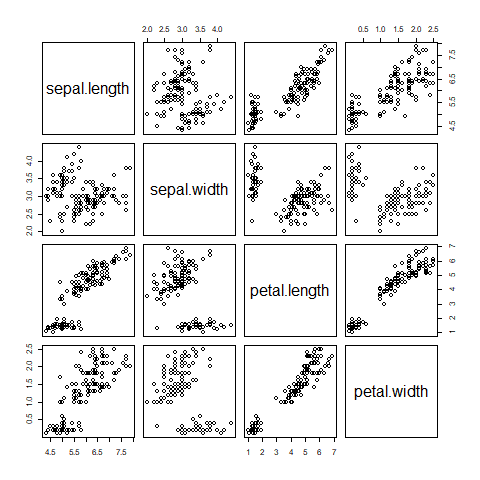

In [4]:
%%R 

df_flower = read.table('iris.csv', sep = ',', header = TRUE)
pca_df = df_flower[,c('sepal.length', 'sepal.width', 'petal.length', 'petal.width')]

pairs(pca_df)

Percebe-se que todas as variáveis parecem ter uma correlação significativa entre si. 

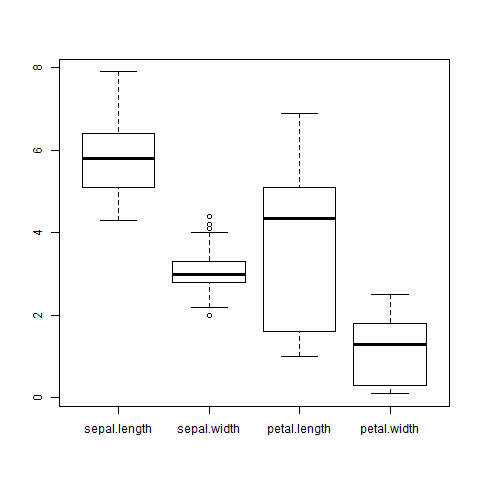

In [5]:
%%R
boxplot(pca_df)

Podemos perceber uma discrepância entre as variâncias, o que nos leva a padronizar as variáveis ao realizar a análise de componentes principais.

In [6]:
%%R
flowers_pca = prcomp(pca_df, center = TRUE,scale. = TRUE)
summary(flowers_pca)

Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.7084 0.9560 0.38309 0.14393
Proportion of Variance 0.7296 0.2285 0.03669 0.00518
Cumulative Proportion  0.7296 0.9581 0.99482 1.00000


Olhando para a proporção de variância explicada, notamos que PC1 e PC2, somadas, explicam aproximadamente 95% da variância do conjunto de dados, logo usaremos apenas essas duas componentes. Em seguida, adquirimos os pesos de cada componente.

In [7]:
%%R
flowers_pca$rotation[, c(1,2)]

                    PC1         PC2
sepal.length  0.5210659 -0.37741762
sepal.width  -0.2693474 -0.92329566
petal.length  0.5804131 -0.02449161
petal.width   0.5648565 -0.06694199


Podemos argumentar que PC1 representa a soma igualmente ponderada do comprimento da sépala e da largura e comprimento da pétala, em contraste com a largura da sépala, podemos chamá-la de componente do tamanho da flor. Já a PC2, oferece mais pesos para as variáveis referentes à sepála, logo podemos interpretá-la como componente do tamanho corpo da flor. 

Text(0, 0.5, 'PC2')

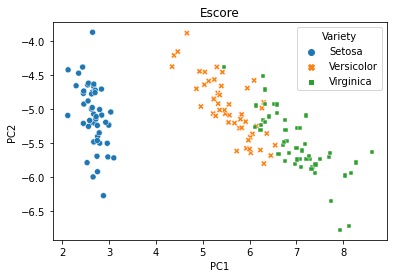

In [8]:
comp = %R -o rvar rvar =flowers_pca$rotation[, c(1,2)]
pca_df = pd.read_csv('iris.csv', sep = ',')
escore = np.dot(pca_df.iloc[:,0:4].to_numpy(), comp)
data_aux = [escore[:,0].T, escore[:,1].T, pca_df['variety'].to_numpy().T]
df_plot = pd.DataFrame(data_aux, index = ['PC1', 'PC2', 'Variety']).T
sns.scatterplot(x = 'PC1', y ='PC2', color = 'teal', data = df_plot, hue = 'Variety', style = 'Variety')
plt.title('Escore')
plt.xlabel('PC1')
plt.ylabel('PC2')

Podemos ver que o plot das componentes PC1 PC2 distingue claramente a variedade Setosa das outras.

# Questão 11.1

a) Calculando a matriz $\hat{a} = (\bar{x_1} - \bar{x_2})S_{pool}^{-1}$

In [47]:

x1 = np.array([[3,2,4], [7,4,7]])
x2 = np.array([[3,5,4], [9,7,8]])
x1_mean = np.array([[3,6]])
x2_mean = np.array([[4,8]])
n1 = len(x1)
n2 = len(x2)

spool = (n1-1/(n1+n2 -2))*np.cov(x1) + (n2-1/(n1+n2 -2))*np.cov(x2) 

#w = (len(x1) + len(x2))* spool

a = np.dot((x1_mean-x2_mean), np.linalg.inv(spool))
print('Matriz a : ', a)




Matriz a :  [[-0.25806452 -0.30107527]]


b) Classificando obsevação $x_0$ com prioris e pesos iguais.

In [35]:
xo = np.array([[2,7]])
y1 = np.dot(a, xo.T)
print('Valor de y_1: ', y1)

Valor de y_1:  [[-2.62365591]]


Assim, como -2.62 é menor do que 0, o valor de referência, a observação $x_0$ é classificada como pertencente ao grupo 2, ou seja, ao grupo $x_2$.

# Questão 11.10

Aplicando o teste $T^2$ de Hotelling, queremos testar:

$$
H_0 : \mu_1 = \mu_2 \quad  \:H_1: \mu_1 \neq \mu_2
$$

$$
T^2 = (\bar{x_1}-\bar{x_2})^T [(\frac{1}{n_1} + \frac{1}{n_2})S_{pooled}]^{-1}(\bar{x_1}-\bar{x_2})
$$

$$
T^2 \sim \frac{(n_1+n_2 -2)p}{(n_1+n_2 -p-1)}F_{p, n_1+n_2-p-1}
$$



In [37]:
from scipy.stats import f
x1 = np.array([[-1,-1]])
x2 = np.array([[2,1]])

spool = np.array([[7.3, -1.1],
                [-1.1,4.8]])

n1 = 11
n2 = 12

t2 = np.dot(np.dot((x1-x2),np.linalg.inv((1/n1+1/n2)*spool)), (x1-x2).T)
t = ((n1+n2-2)*2)/(n1+n2-3)*f.ppf(0.9,2, n1+n2-3)
pvalor = 2*(1-f.cdf(t2,2, n1+n2-3))
print(f'Estatística de Teste: {round(t2[0][0],4)} e quantil : {round(t,4)}')
print(f'p-valor: {round(pvalor[0][0],4)}')

Estatística de Teste: 14.5217 e quantil : 5.4374
p-valor: 0.0003


Logo rejeitamos $H_0$ e há diferença entre as médias

Se $\hat{a} = (\bar{x_1}- \bar{x_2})^TS_{pooled}^{-1}(\bar{x_1} + \bar{x_2})$, então alocamos uma observação $x_0$ em $\pi_0$ se:


$$
\hat{y} = \hat{a}x_0 \geq \frac{1}{2}(\bar{x_1}- \bar{x_2})S_{pooled}^{-1}(\bar{x_1}+ \bar{x_2}) = \hat{m}
$$

e alocamos $\pi_1$ caso contrário.

In [46]:
a = np.dot((x1-x2), np.linalg.inv(spool))
m = 1/2*np.dot(a,(x1+x2).T)

print('Matriz a : ', a)
print('m: ', m[0][0] )

Matriz a :  [[-0.49068874 -0.52911617]]
Matrix m :  -0.24534436890334027


In [59]:
x0 = np.array([[0,1]]).T
y = np.dot(a, x0)
print(f'Valor de y : {round(y[0][0],4)}')


Valor de y : -0.5291


Como o valor de y é menor do que $\hat{m} = -0.2453$, alocamos $x_0$ no grupo $\pi_2$

# Exerício 11.24

In [9]:

df = pd.read_csv('tab_11.dat', sep = '\s+', header = None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'groups']


<AxesSubplot:xlabel='X1', ylabel='X4'>

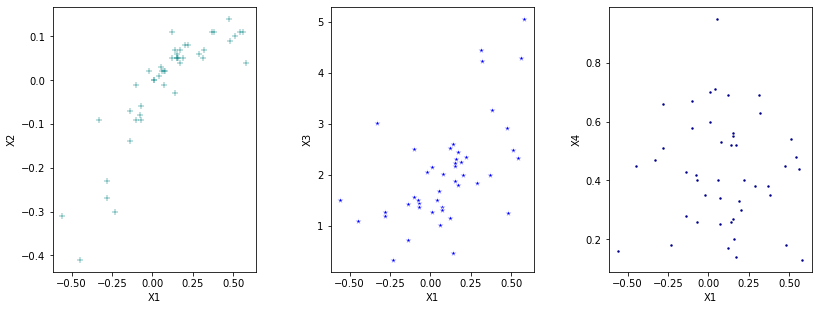

In [10]:
fig, axs = plt.subplots(ncols=3, figsize = (12,5))

axs[0].set_ylabel('X2')
axs[0].set_xlabel('X1')
axs[1].set_ylabel('X3')
axs[1].set_xlabel('X1')
axs[2].set_ylabel('X4')
axs[2].set_xlabel('X1')

fig.tight_layout(pad=3.0)
sns.scatterplot(x = 'x1', y= 'x2', ax = axs[0], data = df, color = 'teal', marker = '+')
sns.scatterplot(x = 'x1', y = 'x3', ax = axs[1], data = df, color = 'blue', marker = '*')
sns.scatterplot(x = 'x1', y = 'x4', ax = axs[2], data = df, color = 'darkblue', marker = '.')

Os pares (x1,x3) e (x1, x4) parecem estar mais próximos de uma distribuição normal multivariada do que o par (x1,x2), sendo o segundo o mais visualmente próximo de uma gaussiana bivariada.

## b) Média e variância amostral

In [4]:
x1 = df.loc[df['groups'] == 0, ['x1', 'x2']]
x2 = df.loc[df['groups'] == 1, ['x1', 'x2']]

mx1 = x1.mean().to_numpy().reshape((1,2))
mx2 = x2.mean().to_numpy().reshape((1,2))
var1 = x1.cov().to_numpy()
var2 = x2.cov().to_numpy()
print('Média X1', mx1)
print('Média X2', mx2)
print('Covar X1', var1)
print('Covar X2', var2)

Média X1 [[-0.06904762 -0.08142857]]
Média X2 [[0.2352 0.0556]]
Covar X1 [[0.04412905 0.02847643]
 [0.02847643 0.02100286]]
Covar X2 [[0.047051   0.00850717]
 [0.00850717 0.00237567]]


## c) Regra de Classificação

Utilizando a regra de classificação quadrática e as restrições em relação as prioris e ao erro, temos que:

$$
-\frac{1}{2}x_0^Tax_0 + bx_0 - k \geq 0
$$

onde $a = (S_1^{-1} - S_2^{-1})$ e b $b = (x_1^TS_1^{-1} - x_2^TS_2^{-1})$

In [5]:
mx1 = x1.mean().to_numpy().reshape((1,2))
mx2 = x2.mean().to_numpy().reshape((1,2))
var1 = x1.cov().to_numpy()
var2 = x2.cov().to_numpy()
lx1 = len(x1)
lx2 = len(x2)

det1 = np.linalg.det(var1)
det2 = np.linalg.det(var2)
inv1 = np.linalg.inv(var1)
inv2 = np.linalg.inv(var2)

a = inv1-inv2
b = np.dot(mx1,inv1)-np.dot(mx2,inv2)
k = 1/2*(np.log(det1/det2) + np.dot(np.dot(mx1, inv1 ), mx1.T) - np.dot(np.dot(mx2, inv2 ), mx2.T))
print('Matriz a: ')
print(a)
print('Matriz b: ')
print(b)
print('Valor de k:  ')
print(round(k[0][0],4))

Matriz a: 
[[ 120.8823196   -29.74938113]
 [ -29.74938113 -813.36239017]]
Matriz b: 
[[  5.31619235 -29.64633318]]
Valor de k:  
0.1624


## d) Análise da Qualidade de Classificação

<AxesSubplot:>

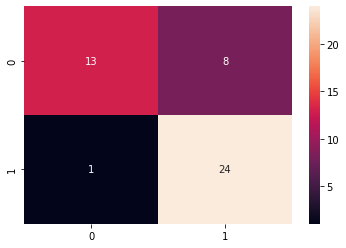

In [6]:
from sklearn.metrics import confusion_matrix
y_true = df['groups']

df1 = df.drop(['groups'], axis = 1)
df1 = df1.drop(['x3', 'x4'], axis = 1)
df1 = df1.to_numpy()
res = []
for i in range(len(df1)):  
    call = -1/2*np.dot(np.dot(df1[i],a), df1[i].T) + np.dot(b, df1[i].T)
    c = call[0]
    if c >= k:
        res.append(0)
    
    else:
        res.append(1)
    
cf_matrix = confusion_matrix(y_true, res)
sns.heatmap(cf_matrix, annot=True)

Assim, o APER é dado por:
    
$$
APER = \frac{9}{46} = 0.1956
$$

## e) Métricas de Avaliação

In [7]:
def discriminant(x1,x2, df):
    lx1 = len(x1)
    lx2 = len(x2)
    mx1 = x1.mean().to_numpy().reshape((1,x1.shape[1]))
    mx2 = x2.mean().to_numpy().reshape((1,x2.shape[1]))
    var1 = x1.cov().to_numpy()
    var2 = x2.cov().to_numpy()
    


    det1 = np.linalg.det(var1)
    det2 = np.linalg.det(var2)
    inv1 = np.linalg.inv(var1)
    inv2 = np.linalg.inv(var2)

    a = inv1-inv2
    b = np.dot(mx1,inv1)-np.dot(mx2,inv2)
    k = 1/2*(np.log(det1/det2) + np.dot(np.dot(mx1, inv1 ), mx1.T) - np.dot(np.dot(mx2, inv2 ), mx2.T))
    
    return a,b,k


def predict(a,b,k, xo, priors = (1,1)):
    
    call = -1/2*np.dot(np.dot(xo,a), xo.T) + np.dot(b, xo.T)
    c = call[0]
    
    if c >= k + np.log(priors[1]/priors[0]):
        classif = 0
    
    else:
        classif = 1
    
    return classif


def confusion(a,b,k, df,  priors = (1,1), confusion = False ):
    
    y_true = df['groups']

    df1 = df.drop(['groups'], axis = 1)
    df1 = df1.to_numpy()
    res = []
    for i in range(len(df1)):  
        call = -1/2*np.dot(np.dot(df1[i],a), df1[i].T) + np.dot(b, df1[i].T)
        c = call[0]
        if c >= k + np.log(priors[1]/priors[0]):
            res.append(0)

        else:
            res.append(1)
    
    
    if confusion == True:
        cf_matrix = confusion_matrix(y_true, res)
        sns.heatmap(cf_matrix, annot=True)
    
    return list(y_true == res).count(False)




In [8]:
df2 = df[['x1', 'x2', 'groups']]

def holdout(x1,x2, df, priors = (1,1)):
    miss1 = 0
    miss2 = 0
    
    
    for i in range(0,len(x1)):
        holdout = df.iloc[i]
        xo = holdout.drop(['groups']).to_numpy()
        xtest = x1.drop(i, axis = 0)
        
        a,b,k = discriminant(xtest, x2, df)
        prediction = predict(a,b,k, xo, priors = priors)
        
        if prediction == holdout['groups']:
            continue
        else:
            miss1 += 1
    
    for i in range(21,21+len(x2)):
        holdout = df.iloc[i]
        xo = holdout.drop(['groups']).to_numpy()
        xtest = x2.drop(i, axis = 0)

        a,b,k = discriminant(x1, xtest, df)
        prediction = predict(a,b,k, xo, priors = priors)

        if prediction == holdout['groups']:

            continue

        else:
            miss2 += 1
        

    
    aer = (miss1+miss2)/(len(x1)+len(x2))
        
        
    return aer

aer = round(holdout(x1,x2,df2),4)
print('AER : ', aer)

AER :  0.2174


## e) Mudando as probabilidades a priori.

AER:  0.2609


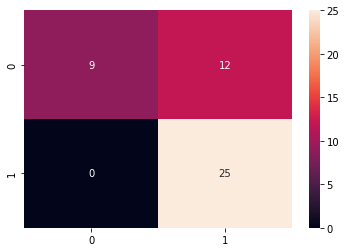

In [9]:

a,b,k = discriminant(x1,x2,df2)
confusion(a,b,k, df2, priors = (0.05,0.95), confusion = True)
aer = round(holdout(x1,x2,df2, priors = (0.05,0.95)),4)
print('AER: ', aer)

Assim, o APER é dado por:
    
$$
APER = \frac{12}{46} = 0.2608
$$

A escolha das probabilidades a priori não é razoável, uma vez que temos 21 observações da população 1 e 25 da população 2. Uma melhor escolha seria suas próprias frequências observadas.

## f) Usando a função discriminante de Fisher

In [19]:
n1 = len(x1)
n2 = len(x2)
var1 = x1.cov().to_numpy()
var2 = x2.cov().to_numpy()
spool = (n1-1/(n1+n2 -2))*var1 + (n2-1/(n1+n2 -2))*var2



a = np.dot((mx1-mx2), np.linalg.inv(spool))
m = 1/2*np.dot(a,(mx1+mx2).T)

print('Matriz a : ', a)
print('m: ', m[0][0] )

Matriz a :  [[-0.10426837 -0.10519175]]
m:  -0.007303743038896707


Logo, a função discriminante de Fisher é dada por:
    
$$
\hat{y} = -0.104x_1 - 0.105x_2
$$

e 
$$
\hat{m} = -0.007
$$

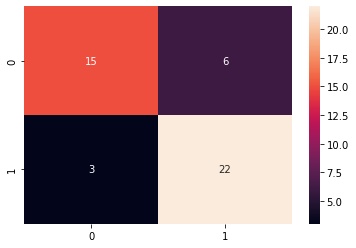

In [27]:
def fisher_dis(df, a,m,  priors = (1,1), confusion = True):
    
    y_true = df['groups']

    df1 = df.drop(['groups'], axis = 1)
    df1 = df1.to_numpy()
    res = []
    for i in range(len(df1)):  
        call = np.dot(a, df1[i])
        c = call[0]
        if c >= m:
            res.append(0)

        else:
            res.append(1)
    
    
    if confusion == True:
        cf_matrix = confusion_matrix(y_true, res)
        sns.heatmap(cf_matrix, annot=True)
        

fisher_dis(df2, a,m)

Assim, o APER é dado por:
    
$$
APER = \frac{9}{46} = 0,1956
$$

Contudo, o uso do discriminante de Fisher não é recomendado, visto que as duas populações tem variâncias diferentes.

## g) Mudando par de variáveis

### (x1,x3)

AER:  0.1304


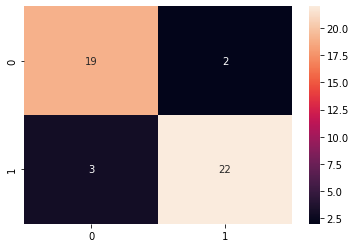

In [320]:
x1 = df.loc[df['groups'] == 0, ['x1', 'x3']]
x2 = df.loc[df['groups'] == 1, ['x1', 'x3' ]]
df3 = df[['x1', 'x3', 'groups']]

a,b,k = discriminant(x1,x2, df3)
confusion(a,b,k, df3, priors = (1,1), confusion = True)
aer = round(holdout(x1,x2,df3, priors = (1,1)),4)

print('AER: ', aer)

Assim, o APER é dado por:
    
$$
APER = \frac{5}{46} = 0.1086
$$

### (x1, x4)

AER:  0.2174


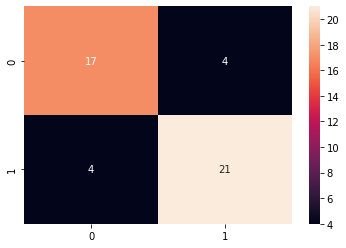

In [321]:
x1 = df.loc[df['groups'] == 0, ['x1', 'x4']]
x2 = df.loc[df['groups'] == 1, ['x1', 'x4' ]]
df4 = df[['x1', 'x4', 'groups']]

a,b,k = discriminant(x1,x2, df)
confusion(a,b,k, df4, priors = (1,1), confusion = True)
aer = round(holdout(x1,x2,df4, priors = (1,1)),4)

print('AER: ', aer)

Assim, o APER é dado por:
    
$$
APER = \frac{8}{46} = 0.1739
$$

## h) Usando todas as covariáveis

In [228]:
x1 = df.loc[df['groups'] == 0, ['x1', 'x2', 'x3', 'x4' ]]
x2 = df.loc[df['groups'] == 1, ['x1', 'x2', 'x3', 'x4' ]]

3

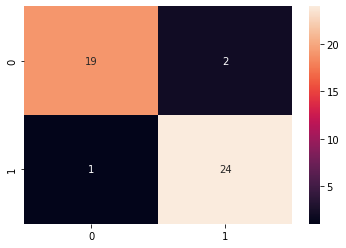

In [239]:
def discriminant(x1,x2, df):
    lx1 = len(x1)
    lx2 = len(x2)
    mx1 = x1.mean().to_numpy().reshape((1,x1.shape[1]))
    mx2 = x2.mean().to_numpy().reshape((1,x2.shape[1]))
    var1 = x1.cov().to_numpy()
    var2 = x2.cov().to_numpy()
    


    det1 = np.linalg.det(var1)
    det2 = np.linalg.det(var2)
    inv1 = np.linalg.inv(var1)
    inv2 = np.linalg.inv(var2)

    a = inv1-inv2
    b = np.dot(mx1,inv1)-np.dot(mx2,inv2)
    k = 1/2*(np.log(det1/det2) + np.dot(np.dot(mx1, inv1 ), mx1.T) - np.dot(np.dot(mx2, inv2 ), mx2.T))
    
    return a,b,k

def confusion(a,b,k, df,  priors = (1,1) ):
    
    y_true = df['groups']

    df1 = df.drop(['groups'], axis = 1)
    df1 = df1.to_numpy()
    res = []
    for i in range(len(df1)):  
        call = -1/2*np.dot(np.dot(df1[i],a), df1[i].T) + np.dot(b, df1[i].T)
        c = call[0]
        if c >= k + np.log(priors[1]/priors[0]):
            res.append(0)

        else:
            res.append(1)
    
    
    
    cf_matrix = confusion_matrix(y_true, res)
    sns.heatmap(cf_matrix, annot=True)
    
    return list(y_true == res).count(False)
a,b,k = discriminant(x1,x2, df)
confusion(a,b,k, df)

Assim, o APER é dado por:
    
$$
APER = \frac{3}{46} = 0.065
$$